# Pipelines using Dask, Kubeflow and MLRun

## Create a project to host functions, jobs and artifacts

Projects are used to package multiple functions, workflows, and artifacts. Project code and definitions are usually stored in a Git archive.

The following code creates a new project in a local dir and initializes git tracking on it.

In [1]:
import os
import mlrun
import warnings

warnings.filterwarnings("ignore")

# set project name, dir, and artifacts path
project_name = "sk-project-dask"
project_dir = "./"
project.artifact_path = path

# set project
sk_dask_proj = mlrun.get_or_create_project(project_name, project_dir, init_git=True)

> 2022-09-27 17:26:14,808 [info] loaded project sk-project-dask from MLRun DB


## Init Dask cluster

In [2]:
import mlrun

# set up function from local file
project = mlrun.get_or_create_project("dsf")
dsf = project.set_function(name="mydask", kind="dask", image="mlrun/mlrun")

# set up function specs for dask
dsf.spec.remote = True
dsf.spec.replicas = 5
dsf.spec.service_type = "NodePort"
dsf.with_limits(mem="6G")
dsf.spec.nthreads = 5

In [3]:
# apply mount_v3io over the function so that the k8s pod that runs the function
# can access the data (shared data access)
dsf.apply(mlrun.mount_v3io())

In [4]:
dsf.save()

'db://sk-project-dask/mydask'

In [5]:
# init dask cluster
dsf.client

> 2022-09-27 17:26:25,134 [info] trying dask client at: tcp://mlrun-mydask-d7df9301-d.default-tenant:8786
> 2022-09-27 17:26:25,162 [info] using remote dask scheduler (mlrun-mydask-d7df9301-d) at: tcp://mlrun-mydask-d7df9301-d.default-tenant:8786


Connection method: Direct,
Dashboard: http://mlrun-mydask-d7df9301-d.default-tenant:8787/status,
Comm: tcp://10.200.152.178:8786,Workers: 0
Dashboard: http://10.200.152.178:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load and run a functions

Load the function object from .py or .yaml file, or the Function Hub (marketplace).<br>

In [6]:
# load function from the Function Hub
sk_dask_proj.set_function("hub://describe", name="describe")
sk_dask_proj.set_function("hub://sklearn_classifier_dask", name="dask_classifier")

## Create a fully automated ML pipeline

### Add more functions to the project to be used in the pipeline (from the Function Hub)

Describe data, train and eval model with dask.

### Define and save a pipeline

The following workflow definition is written into a file. It describes a Kubeflow execution graph (DAG) 
and how functions and data are connected to form an end-to-end pipeline. 

* Describe data.
* Train, test and evaluate with dask.

Check the code below to see how functions objects are initialized and used (by name) inside the workflow.<br>
The `workflow.py` file has two parts, initialize the function objects and define pipeline dsl (connect the function inputs and outputs).

> Note: The pipeline can include CI steps like building container images and deploying models as illustrated in the following example.


In [7]:
%%writefile workflow.py
import os
from kfp import dsl
import mlrun

# params
funcs = {}
LABELS = "label"
DROP = "congestion_surcharge"
DATA_URL = mlrun.get_sample_path("data/iris/iris_dataset.csv")
DASK_CLIENT = "db://sk-project-dask/mydask"


# init functions are used to configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    for f in functions.values():
        f.apply(mlrun.mount_v3io())
        pass


@dsl.pipeline(name="Demo training pipeline", description="Shows how to use mlrun")
def kfpipeline():
    # Describe the data
    describe = funcs["describe"].as_step(
        inputs={"table": DATA_URL},
        params={"dask_function": DASK_CLIENT},
    )

    # Train, test and evaluate:
    train = funcs["dask_classifier"].as_step(
        name="train",
        handler="train_model",
        inputs={"dataset": DATA_URL},
        params={
            "label_column": LABELS,
            "dask_function": DASK_CLIENT,
            "test_size": 0.10,
            "model_pkg_class": "sklearn.ensemble.RandomForestClassifier",
            "drop_cols": DROP,
        },
        outputs=["model", "test_set"],
    )
    train.after(describe)

Overwriting workflow.py


In [8]:
# register the workflow file as "main", embed the workflow code into the project YAML
sk_dask_proj.set_workflow("main", "workflow.py", embed=False)

Save the project definitions to a file (project.yaml). It is recommended to commit all changes to a Git repo.

In [9]:
sk_dask_proj.save()

<a id='run-pipeline'></a>
## Run a pipeline workflow
Use the `run` method to execute a workflow. You can provide alternative arguments and specify the default target for workflow artifacts.<br>
The workflow ID is returned and can be used to track the progress or you can use the hyperlinks.

> Note: The same command can be issued through CLI commands:<br>
    `mlrun project my-proj/ -r main -p "v3io:///users/admin/mlrun/kfp/{{workflow.uid}}/"`

The `dirty` flag lets you run a project with uncommitted changes (when the notebook is in the same git dir it is always dirty).<br>
The `watch` flag waits for the pipeline to complete and print results.

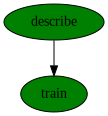

uid,start,state,name,parameters,results
...25cd95b4,Sep 27 17:27:09,completed,train,label_column=labeldask_function=db://sk-project-dask/mydasktest_size=0.1model_pkg_class=sklearn.ensemble.RandomForestClassifierdrop_cols=congestion_surcharge,micro=0.9944598337950138macro=0.9945823158323159precision-0=1.0precision-1=0.9166666666666666precision-2=0.8recall-0=1.0recall-1=0.7857142857142857recall-2=0.9230769230769231f1-0=1.0f1-1=0.8461538461538461f1-2=0.8571428571428571
...6516a656,Sep 27 17:26:42,completed,describe,dask_function=db://sk-project-dask/mydask,


In [10]:
artifact_path = os.path.abspath("./pipe/{{workflow.uid}}")
run_id = sk_dask_proj.run(
    "main", arguments={}, artifact_path=artifact_path, dirty=False, watch=True
)

**[back to top](#top)**